This notebook performs knn linear regression on our honey production and air quality combined dataset, which is read in in the second cell<br>
Nearest neighbors are found using only the geographical (latitude and longitude) features - so it is not knn in the classical sense<br>
We use the matrix solution to minimize the MSE<br>
Cross validation is performed and an MSE is output near the end. Everything is written from scratch with numpy

In [1]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True) # disable scientific notation when printing

In [2]:
data = pd.read_csv("data/completeFeatureVectors.csv")

X = data[['o3','co','so2','no2','pm25_frm', 'pressure', 'temperature', 'wind', 'year']].to_numpy()
# subtract 1998 from the year so that it starts at zero
X[:,8] = X[:,8]-1998
# Append ones to the start of X for the bias term
X = np.append(np.ones((X.shape[0],1)), X, axis=1)
y = data[['yield_per_col']].to_numpy()

The predict function makes a prediction for the query given the training data X and responses y

In [3]:
def predict(query, X, y, k=50):
    distances = []
    for x in X:
        distances.append(np.linalg.norm(query-x))
    
    # determine the cutoff for being one of k nearest neighbors
    # np.sort returns a copy of distances so distances isn't affected
    cutoff = np.sort(distances)[k]
    # find the neighbors with a distance less than the cutoff
    X_neighbors = X[distances<cutoff][:,:10]
    y_neighbors = y[distances<cutoff]

    # find theta with matrix formula to minimize MSE
    theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_neighbors.T, X_neighbors)),X_neighbors.T),y_neighbors)

    # return prediction found via theta
    return np.matmul(query.T, theta)

Perform k-fold cross validation to find our mean squared error (MSE)

median sq error: 60.239163835357594
mean sq error: 549.5460115594382


Text(0.5, 1.0, 'Distribution Squared Error Terms')

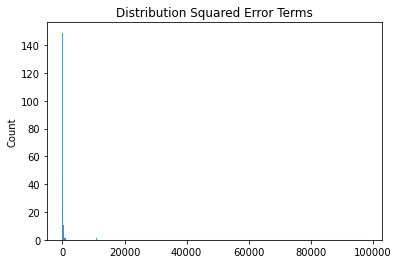

In [4]:
k = 10

# the size of the testing set for each fold
chunk_size = X.shape[0] // k

# shuffle X and y together
Xy_shuffled = np.append(X, y, axis=1)
np.random.shuffle(Xy_shuffled)

sq_errors = []

# iterate through k folds
for i in range(k):

    # split out testing and training data
    X_k_test = Xy_shuffled[chunk_size*i:chunk_size*(i+1),:10]
    y_k_test = Xy_shuffled[chunk_size*i:chunk_size*(i+1),10]

    if i == 0:
        X_k_train = Xy_shuffled[chunk_size:,:10]
        y_k_train = Xy_shuffled[chunk_size:,10]
    elif i == k-1:
        X_k_train = Xy_shuffled[:chunk_size*i,:10]
        y_k_train = Xy_shuffled[:chunk_size*i,10]
    else:
        X_k_train = np.append(Xy_shuffled[:chunk_size*i,:10], Xy_shuffled[chunk_size*(i+1):,:10], axis=0)
        y_k_train = np.append(Xy_shuffled[:chunk_size*i,10], Xy_shuffled[chunk_size*(i+1):,10], axis=0)

    for j in range(X_k_test.shape[0]):
        y_pred = predict(X_k_test[j,:], X_k_train, y_k_train, k=30)
        # if (y_pred - y_k_test[j])**2 > 1000:
        #     print("predicted:", y_pred, "actual", y_k_test[j], "se:", (y_pred - y_k_test[j])**2)
        sq_errors.append((y_pred - y_k_test[j])**2)
    
mean_sq_error = np.mean(sq_errors)
print("median sq error:", np.median(sq_errors))
print("mean sq error:", mean_sq_error)

sns.histplot(data=sq_errors).set_title("Distribution Squared Error Terms")